In [493]:
# Cell 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib
import requests
from datetime import datetime
import json
from sklearn.preprocessing import StandardScaler

In [494]:
# Cell 2: Load and Preprocess Data
# Load the dataset
df = pd.read_csv('coconut_irrigation_data_with_water_level_8.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert soil type to numerical
soil_type_mapping = {
    'Lateritic': 1,
    'Sandy Loam': 2,
    'Cinnamon Sand': 3,
    'Red Yellow Podzolic': 4,
    'Alluvial': 5
}

df['Soil Type'] = df['Soil Type'].map(soil_type_mapping)
joblib.dump(soil_type_mapping, 'soil_type_mapping.pkl')

['soil_type_mapping.pkl']

In [495]:
# Cell 3: Define Water Level Categories
def categorize_water_level(water_level):
    if 50 <= water_level <= 100:
        return 1  # High water need
    elif 30 <= water_level < 50:
        return 2  # Moderate water need
    elif 10 <= water_level < 30:
        return 3  # Low water need
    else:
        return 0  # No water needed

# Apply categorization
df['Water Level Category'] = df['Water Level (liters)'].apply(categorize_water_level)


In [496]:
# Cell 4: Prepare Features and Target
# Select features including Soil Type
X = df[[
    'Soil Type',
    'Soil Moisture (10 cm) (%)',
    'Soil Moisture (20 cm) (%)',
    'Soil Moisture (30 cm) (%)',
    'Plant Age (years)',
    'Temperature (°C)',
    'Humidity (%)',
    'Rainfall (mm)'
]]
y = df['Water Level Category']

In [497]:
# Cell 5: Apply SMOTE and Split Data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [498]:
# Cell 6: Helper Functions
def get_water_level_range_string_from_category(category):
    if category == 1:
        return "50-100L\n(High)"
    elif category == 2:
        return "30-50L\n(Moderate)"
    elif category == 3:
        return "10-30L\n(Low)"
    elif category == 0:
        return "0L\n(None)"
    else:
        raise ValueError("Invalid category. Must be 0, 1, 2, or 3.")

In [499]:
df.head(6)

,Date,Soil Type,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Irrigation Status (0/1),Water Level (liters),Water Level Category
0,2020-04-22,4,36.867627,21.865596,38.507507,10,25.307124,73.814358,2.578859,1,0,0.000000,0
1,2023-12-03,1,59.917928,52.812786,56.767034,10,25.307124,73.814358,0.000000,0,0,0.000000,0
2,2020-08-29,4,22.763336,16.576376,22.598885,7,29.987019,78.942960,0.000000,0,1,98.103466,1
3,2021-03-18,3,46.065484,61.316373,43.299673,7,29.987019,78.942960,14.848499,1,0,0.000000,0
4,2023-05-27,2,19.697741,31.192243,29.383629,6,32.358858,67.739955,0.000000,0,1,76.159349,1
5,2021-05-14,5,30.295711,62.770718,73.610180,6,32.358858,67.739955,0.000000,0,0,36.473645,2


In [ ]:
def evaluate_single_model(model, X_scaled, X_test_scaled, y_train, y_test, name):
    """Helper function to evaluate and visualize a single model"""
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_correct = conf_matrix.diagonal()
    class_total = conf_matrix.sum(axis=1)
    class_accuracy = class_correct / class_total * 100
    
    water_level_labels = [get_water_level_range_string_from_category(i) for i in range(4)]
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    # Bar plot
    bars = ax1.bar(range(4), class_accuracy, color=colors)
    ax1.set_title(f'Prediction Accuracy by Water Need Level\n{name}', pad=20)
    ax1.set_xlabel('Water Need Category (Liters)')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xticks(range(4))
    ax1.set_xticklabels(water_level_labels, rotation=0)
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Pie chart
    class_percentages = (class_total / class_total.sum()) * 100
    wedges, texts, autotexts = ax2.pie(class_percentages,
                                      labels=water_level_labels,
                                      colors=colors,
                                      autopct='%1.1f%%',
                                      startangle=90)
    
    plt.setp(autotexts, size=8, weight="bold")
    plt.setp(texts, size=8)
    ax2.set_title(f'Distribution of Water Need Categories\n{name}', pad=20)
    
    legend_labels = [
        '0L (No water needed)',
        '50-100L (High water need)',
        '30-50L (Moderate water need)',
        '10-30L (Low water need)'
    ]
    ax2.legend(wedges, legend_labels,
              title="Water Need Categories",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, model

def train_and_evaluate_models():
    """Main function to train and evaluate all models"""
    # Initialize scaler
    scaler = StandardScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save scaler for predictions
    joblib.dump(scaler, 'scaler.pkl')
    
    models = {
        'RandomForest': RandomForestClassifier(
            random_state=42,
            n_estimators=100
        ),
        'DecisionTree': DecisionTreeClassifier(
            random_state=42,
            max_depth=10
        ),
        'LogisticRegression': LogisticRegression(
            random_state=42,
            max_iter=2000,
            solver='lbfgs',
            multi_class='multinomial',
            C=1.0,
            class_weight='balanced'
        )
    }
    
    best_accuracy = 0
    best_model = None
    accuracies = []
    model_names = []
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining and evaluating {name}...")
        model.fit(X_scaled, y_train)
        #call evaluate model
        accuracy, trained_model = evaluate_single_model(
            model, X_scaled, X_test_scaled, y_train, y_test, name
        )
        
        accuracies.append(accuracy * 100)
        model_names.append(name)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = trained_model
    
    # Plot model comparison
    plt.figure(figsize=(10, 6))
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    
    bars = plt.bar(model_names, accuracies, color=colors, width=0.6)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom',
                fontweight='bold')
    
    plt.title('Model Accuracy Comparison', pad=20, fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.ylim(0, 100)
    
    plt.axhline(y=90, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=80, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=70, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save best model
    print(f"\nBest Model: {best_model.__class__.__name__}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    joblib.dump(best_model, 'best_model.pkl')
    
    return best_model

In [501]:
# Cell 8: Weather and Prediction Functions
def get_weather_data(city_name, api_key):
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    
    try:
        params = {
            'q': city_name,
            'appid': api_key,
            'units': 'metric'
        }
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        weather_data = response.json()
        
        return {
            'temperature': weather_data['main']['temp'],
            'humidity': weather_data['main']['humidity'],
            'rainfall': weather_data.get('rain', {}).get('1h', 0)
        }
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

def predict_water_need(soil_type, moisture_10cm, moisture_20cm, moisture_30cm,
                      plant_age, temperature, humidity, rainfall):
    try:
        model = joblib.load('best_model.pkl')
        scaler = joblib.load('scaler.pkl')
        soil_mapping = joblib.load('soil_type_mapping.pkl')
        
        new_data = pd.DataFrame({
            'Soil Type': [soil_mapping[soil_type]],
            'Soil Moisture (10 cm) (%)': [moisture_10cm],
            'Soil Moisture (20 cm) (%)': [moisture_20cm],
            'Soil Moisture (30 cm) (%)': [moisture_30cm],
            'Plant Age (years)': [plant_age],
            'Temperature (°C)': [temperature],
            'Humidity (%)': [humidity],
            'Rainfall (mm)': [rainfall]
        })
        
        new_data_scaled = scaler.transform(new_data)
        prediction = model.predict(new_data_scaled)[0]
        probabilities = model.predict_proba(new_data_scaled)[0]
        
        return prediction, probabilities
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

def predict_with_weather(soil_type, moisture_10cm, moisture_20cm, moisture_30cm, 
                        plant_age, city_name, api_key):
    weather_data = get_weather_data(city_name, api_key)
    
    if weather_data is None:
        return None, None, None, None
    
    input_data = {
        'soil_type': soil_type,
        'moisture_10cm': moisture_10cm,
        'moisture_20cm': moisture_20cm,
        'moisture_30cm': moisture_30cm,
        'plant_age': plant_age,
        'temperature': weather_data['temperature'],
        'humidity': weather_data['humidity'],
        'rainfall': weather_data['rainfall']
    }
    
    prediction, probabilities = predict_water_need(**input_data)
    
    return prediction, probabilities, input_data, weather_data

In [502]:
# Cell 9: Visualization Function
def visualize_prediction_with_weather(prediction, probabilities, input_data, weather_data, model_name):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f'Prediction Results using {model_name}', fontsize=14, fontweight='bold', y=1.02)
    
    gs = plt.GridSpec(1, 2, width_ratios=[1.5, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    categories = ['No Water\n(0L)', 'High\n(50-100L)', 'Moderate\n(30-50L)', 'Low\n(10-30L)']
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    bars = ax1.bar(categories, probabilities * 100, color=colors)
    ax1.set_title('Water Need Prediction Probabilities', pad=20)
    ax1.set_xlabel('Water Need Categories')
    ax1.set_ylabel('Probability (%)')
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    ax2.axis('off')
    summary_text = [
        f"Prediction Summary",
        f"{'=' * 40}",
        f"Model: {model_name}",
        f"Soil Type: {input_data['soil_type']}",
        f"Predicted Need: {get_water_level_range_string_from_category(prediction)}",
        f"\nEnvironmental Conditions:",
        f"Temperature: {input_data['temperature']:.1f}°C",
        f"Humidity: {input_data['humidity']:.1f}%",
        f"Plant Age: {input_data['plant_age']} years",
        f"Rain Status: {'Yes' if input_data['rainfall'] else 'No'}",
        f"\nWeather Details:",
        f"Rainfall (1h): {weather_data['rainfall']:.1f}mm",
        f"\nConfidence Level:",
        f"Prediction Confidence: {max(probabilities)*100:.1f}%",
        f"\nLast Updated: {datetime.now().strftime('%Y-%m-%d %H:%M')}"
    ]
    
    ax2.text(0, 0.95, '\n'.join(summary_text),
             fontsize=10, fontfamily='monospace',
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()


Training and evaluating RandomForest...

Model: RandomForest
Accuracy: 0.8788052843193567
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       440
           1       0.89      0.84      0.86       449
           2       0.78      0.81      0.80       431
           3       0.86      0.92      0.89       421

    accuracy                           0.88      1741
   macro avg       0.88      0.88      0.88      1741
weighted avg       0.88      0.88      0.88      1741



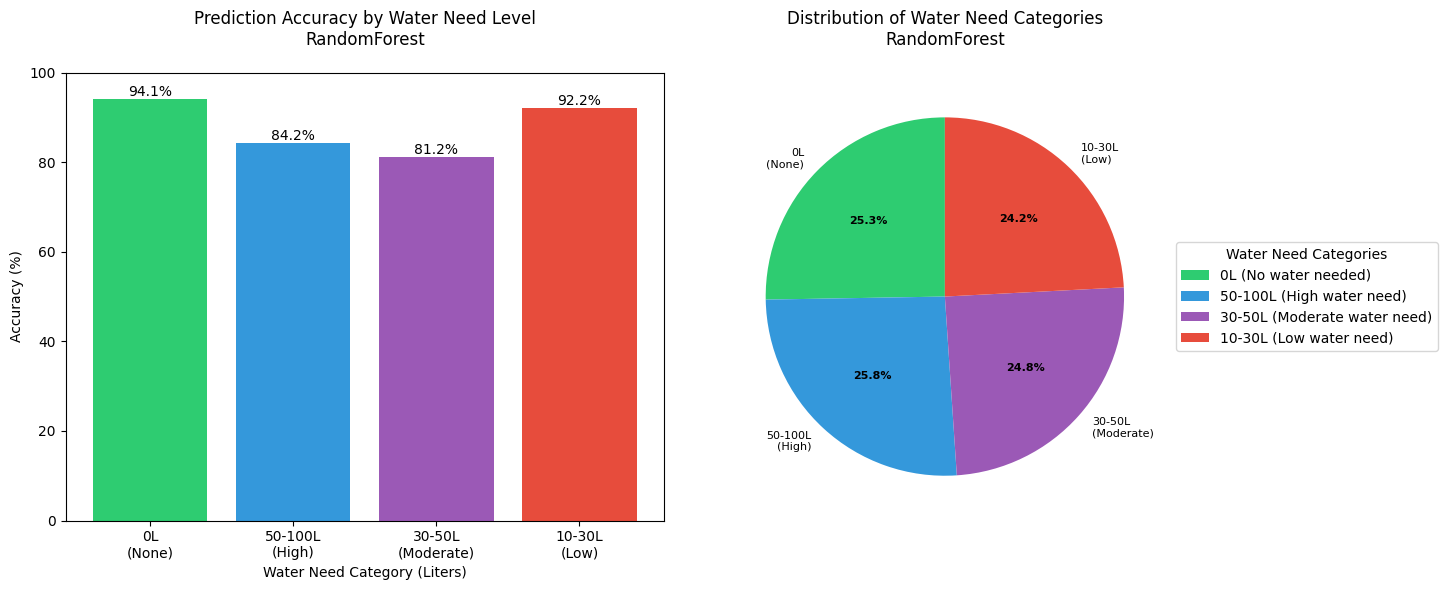


Training and evaluating DecisionTree...

Model: DecisionTree
Accuracy: 0.8299827685238369
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       440
           1       0.83      0.80      0.81       449
           2       0.70      0.72      0.71       431
           3       0.82      0.86      0.84       421

    accuracy                           0.83      1741
   macro avg       0.83      0.83      0.83      1741
weighted avg       0.83      0.83      0.83      1741



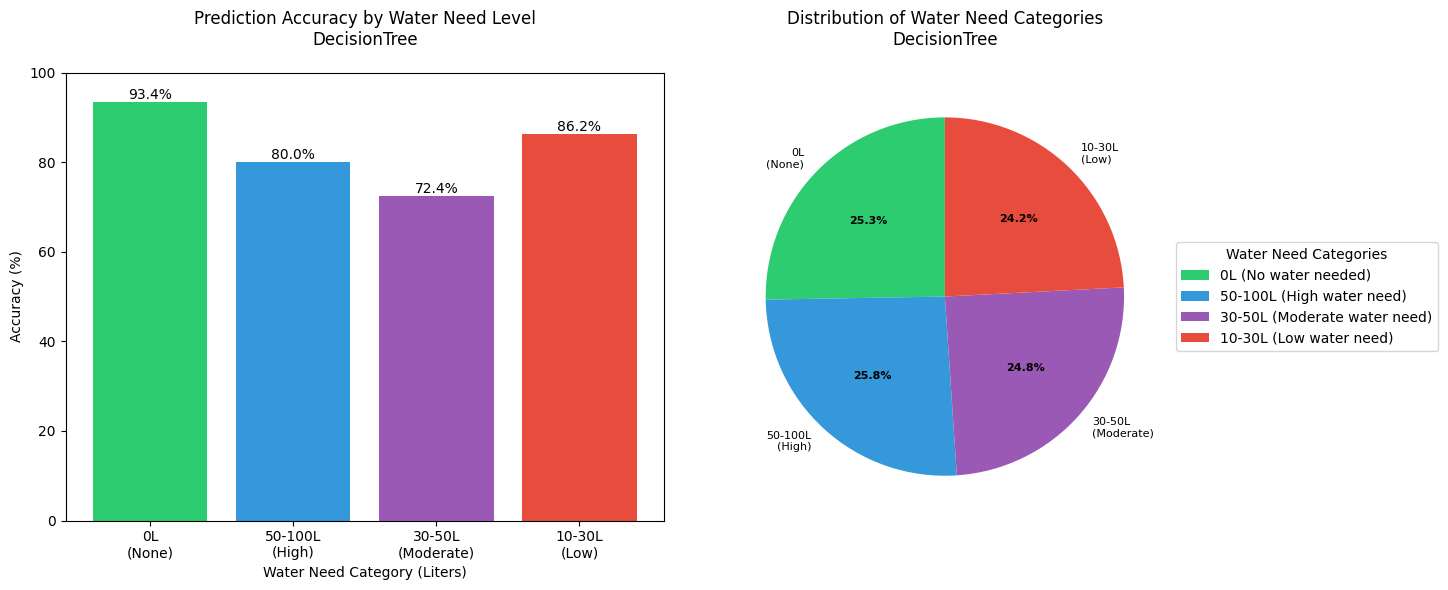


Training and evaluating LogisticRegression...

Model: LogisticRegression
Accuracy: 0.7937966685812752
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       440
           1       0.82      0.79      0.80       449
           2       0.64      0.68      0.66       431
           3       0.76      0.84      0.80       421

    accuracy                           0.79      1741
   macro avg       0.80      0.79      0.80      1741
weighted avg       0.81      0.79      0.80      1741



c:\Users\sadee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


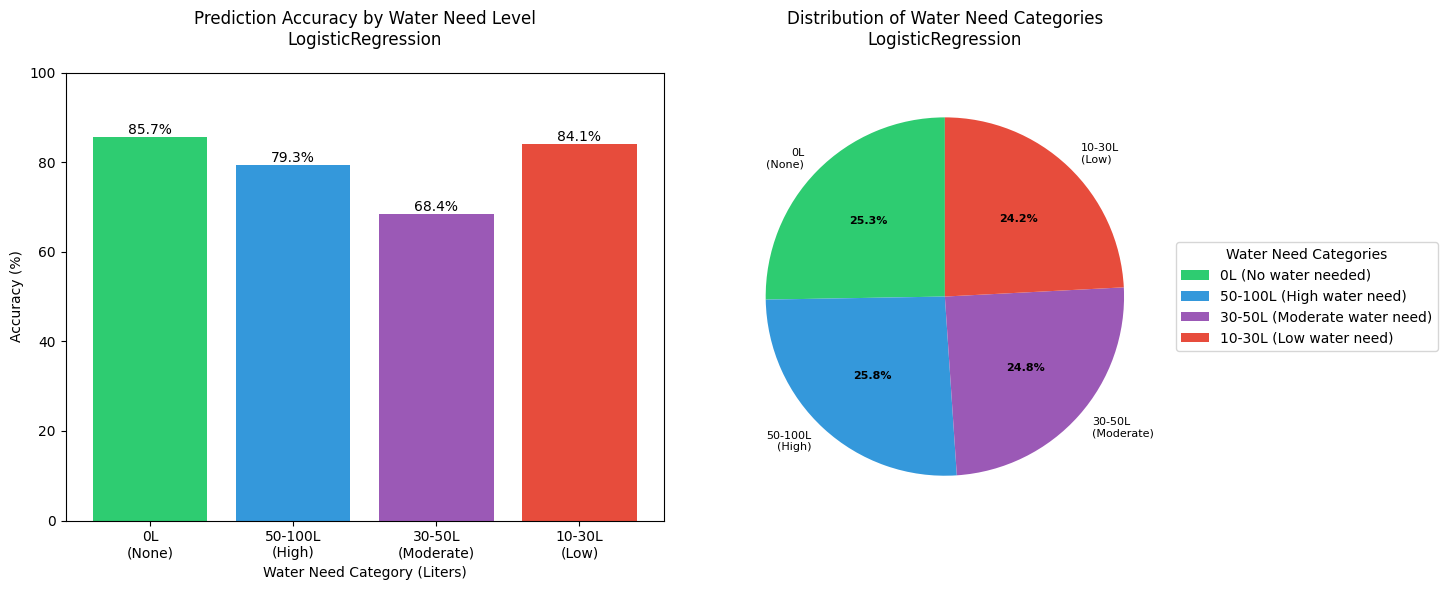

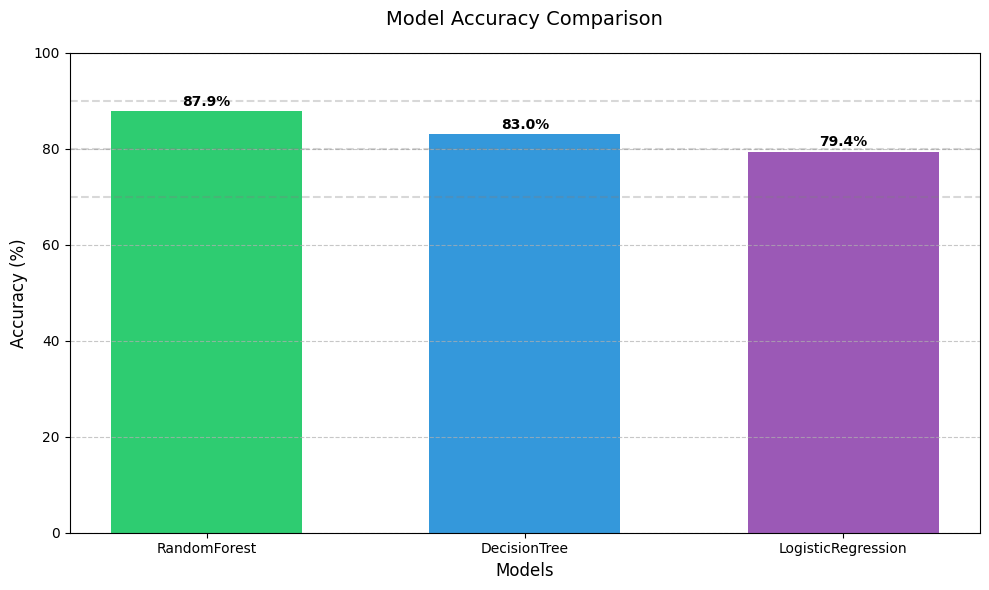


Best Model: RandomForestClassifier
Best Accuracy: 0.8788


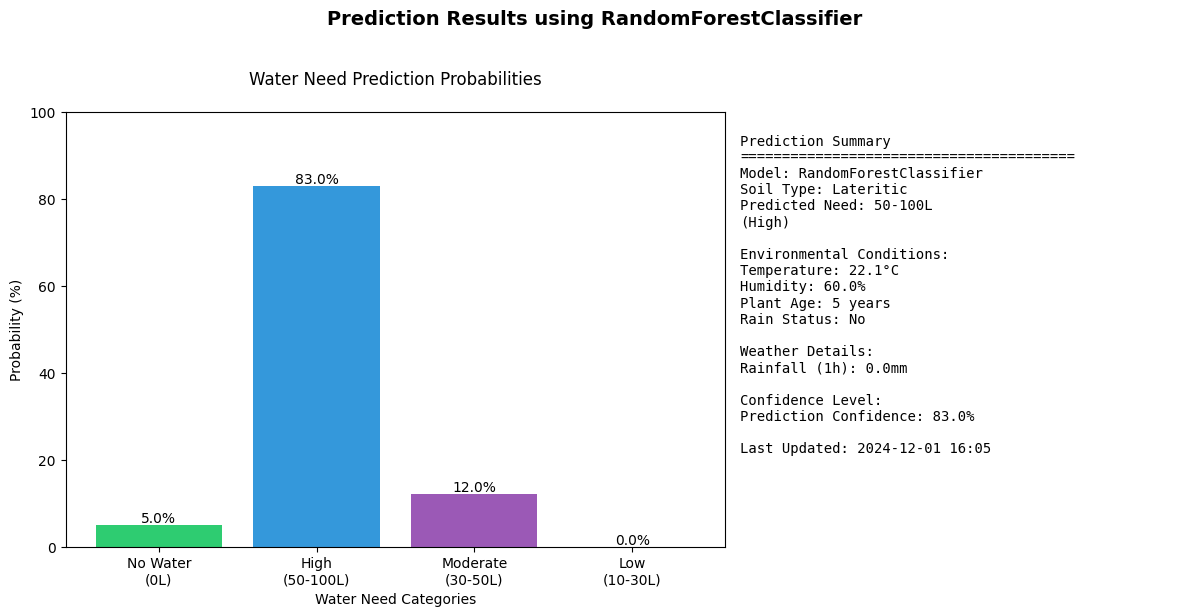


Detailed Prediction Results:
--------------------------------------------------
Model Used: RandomForestClassifier
Predicted Category: 1

Category Probabilities:
No Water: 5.0%
High (50-100L): 83.0%
Moderate (30-50L): 12.0%
Low (10-30L): 0.0%


In [503]:
def main():
    api_key = "5dd16e6569f3cdae6509d32002b9dc67"
    city_name = "Bandarawela"
    
    # Train and evaluate models once
    best_model = train_and_evaluate_models()
    
    # Make prediction with real-time weather
    prediction, probabilities, input_data, weather_data = predict_with_weather(
        soil_type='Lateritic',
        moisture_10cm=14.477,
        moisture_20cm=24.64,
        moisture_30cm=36.25,
        plant_age=5,
        city_name=city_name,
        api_key=api_key
    )
    
    if prediction is not None and probabilities is not None:
        visualize_prediction_with_weather(
            prediction, probabilities, input_data, weather_data, 
            best_model.__class__.__name__
        )
        
        # Print detailed numerical results
        print("\nDetailed Prediction Results:")
        print("-" * 50)
        print(f"Model Used: {best_model.__class__.__name__}")
        print(f"Predicted Category: {prediction}")
        print("\nCategory Probabilities:")
        categories = ['No Water', 'High (50-100L)', 'Moderate (30-50L)', 'Low (10-30L)']
        for cat, prob in zip(categories, probabilities):
            print(f"{cat}: {prob*100:.1f}%")
    else:
        print("Error in prediction. Please check input data.")

if __name__ == "__main__":
    main()